# SIC Curve Analysis Notebook

A streamlined version with clear sections and helper functions.

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# Add these:
from tensorflow.keras.layers import Dense, Flatten, Dropout

# GPU configuration
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
strategy = tf.distribute.MirroredStrategy()


2025-05-02 07:48:53.086271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 07:48:53.086310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 07:48:53.087508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 07:48:53.094384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 07:48:54.356828: W tensorflow/compiler/tf2

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-05-02 07:49:01.323407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-05-02 07:49:01.325320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-05-02 07:49:01.327105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2025-05-02 07:49:01.328775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

### Helper Functions for Data Preparation, Training, Evaluation, and Plotting

This section defines utility functions used throughout the model development pipeline. It includes:

- `load_data`: Loads the dataset from a specified path and key, with optional scaling to TeV units.
- `prepare_inputs`: Prepares the input features and labels from a DataFrame, reshaping features into the required model input shape.
- `build_callbacks`: Constructs a list of Keras callbacks including early stopping and model checkpointing based on validation loss.
- `compute_sic`: Computes the Significance Improvement Characteristic (SIC) curve, defined as TPR / √(FPR + ε), to evaluate model performance in rare signal detection.
- `plot_sic_curves`: Plots the SIC curve from a list of (label, TPR, SIC) tuples for visual comparison between models.

These functions modularize the core components of data handling and evaluation, enabling cleaner model training and reproducibility.


In [2]:
# ===== Helper Functions =====
def load_data(path, key, scale_to_tev=True):
    return load_m_mx_my_tau12_tau23(path, key=key, scale_to_tev=scale_to_tev)

def prepare_inputs(df):
    X = df[['mj1','tau12j1','tau23j1','mj2','tau12j2','tau23j2']].values.reshape(-1,2,3)
    y = df['label'].astype(np.float32).values
    return X, y

def build_callbacks(key):
    os.makedirs('models', exist_ok=True)
    return [
        tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f'models/best_{key}.h5',
                                           'val_loss', save_best_only=True)
    ]

from sklearn.metrics import roc_curve
import numpy as np

def compute_sic(y_true, y_pred, eps=1e-4):
    """
    Compute TPR vs. SIC = TPR / sqrt(FPR + eps),
    where eps prevents division-by-zero.
    Returns (tpr, sic).
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred, drop_intermediate=False)
    sic = tpr / np.sqrt(fpr + eps)
    # clean up any residual NaNs or infs just in case
    sic = np.nan_to_num(sic, nan=0.0, posinf=0.0, neginf=0.0)
    return tpr, sic



def plot_sic_curves(results, title):
    plt.figure(figsize=(8,6))
    for label, tpr, sic in results:
        plt.plot(tpr, sic, label=label)
    plt.title(title)
    plt.xlabel('Signal Efficiency (TPR)')
    plt.ylabel('SIC (TPR / √max(FPR,fpr_min))')
    plt.legend()
    plt.tight_layout()
    plt.show()


### HDF5 Loader: `load_m_mx_my_tau12_tau23`

This function loads and processes event data from an HDF5 file. It performs the following steps:

- Reads a DataFrame from the given `file_path` and `key` (default is `"/df"`).
- If specified, assigns a constant label to all rows using `assign_label`.
- Optionally rescales jet mass features (`mj1`, `mj2`) from GeV to TeV.
- Ensures that all required tau variables (`tau12`, `tau23`) for each jet are computed, even if missing, by calculating ratios from available `tau1`, `tau2`, and `tau3` values.
- Fills in missing columns (`mx`, `my`, `label`, and all needed features) with zeros to ensure a consistent schema.
- Returns a cleaned and standardized DataFrame with the following columns:
  - `mj1`, `tau12j1`, `tau23j1`, `mj2`, `tau12j2`, `tau23j2`, `mx`, `my`, and optionally `label`.

This preprocessing step ensures all necessary features are available for model input, regardless of the original file structure.


In [3]:
###############################################################################
# 2. Load from HDF5: ensures m, mx, my, tau12, tau23, label exist
###############################################################################
def load_m_mx_my_tau12_tau23(
    file_path: str,
    key: str = "/df",
    scale_to_tev: bool = False,
    assign_label: int = None
) -> pd.DataFrame:
    """
    Reads HDF5 (file_path) under group 'key' into a DataFrame.
    - If 'assign_label' is an integer, sets 'label' to that.
    - If 'scale_to_tev' is True, multiply masses by 0.001.
    - Ensures columns: mj1, mj2, tau12j1, tau23j1, tau12j2, tau23j2, mx, my, label.
    """
    df = pd.read_hdf(file_path, key=key)

    # Assign label 
    if assign_label is not None:
        df["label"] = assign_label

    # scale from GeV to TeV
    scale = 0.001 if scale_to_tev else 1.0

    for j in ["j1", "j2"]:
        mcol = f"m{j}"
        if mcol not in df.columns:
            df[mcol] = 0.0
        df[mcol] *= scale

        for base in ["tau1", "tau2", "tau3"]:
            if f"{base}{j}" not in df.columns:
                df[f"{base}{j}"] = 0.0

        tau1 = df[f"tau1{j}"]
        tau2 = df[f"tau2{j}"]
        tau3 = df[f"tau3{j}"]
        mask_12 = (tau1 > 0) & (tau2 > 0)
        mask_23 = (tau2 > 0) & (tau3 > 0)
        df[f"tau12{j}"] = np.where(mask_12, tau2 / tau1, 0.0)
        df[f"tau23{j}"] = np.where(mask_23, tau3 / tau2, 0.0)

    if "mx" not in df.columns:
        df["mx"] = 0.0
    if "my" not in df.columns:
        df["my"] = 0.0

    needed_cols = [
        "mj1", "tau12j1", "tau23j1",
        "mj2", "tau12j2", "tau23j2",
        "mx", "my"
    ]
    if "label" in df.columns:
        needed_cols.append("label")

    
    for c in needed_cols:
        if c not in df.columns:
            df[c] = 0.0

    return df[needed_cols].copy()

### Model Definitions: Supervised and Ideal Weakly Supervised Architectures

This section defines the neural network architectures used for supervised and weakly supervised learning:

- **`base_highlevel_model`**:  
  A configurable base model that:
  - Accepts a `(2, 3)` input shape (e.g., 2 jets × 3 features),
  - Uses a flattened fully connected architecture with 3 hidden layers: 256 → 128 → 64 units (all ReLU),
  - Ends with a sigmoid output layer for binary classification,
  - Supports an optional custom loss: `ScaledBinaryCrossentropy` for weakly supervised training.

- **`simple_supervised_model`**:  
  Returns a base model using standard binary cross-entropy loss. This is used for fully supervised training.

- **`ideal_weakly_supervised_model`**:  
  Returns the same architecture as above but compiles the model with the `ScaledBinaryCrossentropy` loss function, which helps calibrate predictions under label uncertainty in weak supervision.

These models are compiled with the Adam optimizer and include binary accuracy as a performance metric.


In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from aliad.interface.tensorflow.losses import ScaledBinaryCrossentropy  
import numpy as np

def base_highlevel_model(name="BaseModel", input_name="input_features", input_shape=(2, 3), use_scaled_bce=False):
    inputs = Input(shape=input_shape, name=input_name)
    x = Flatten()(inputs)

    x = Dense(256, activation="relu")(x)
    #x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name=name)

    if use_scaled_bce:
        loss_fn = ScaledBinaryCrossentropy(offset=-np.log(2), scale=1000)
    else:
        loss_fn = "binary_crossentropy"

    model.compile(optimizer=Adam(learning_rate=1e-3), loss=loss_fn, metrics=["accuracy"])
    return model

def simple_supervised_model():
    return base_highlevel_model(name="SimpleSupervisedModel", input_name="input_features", use_scaled_bce=False)

def ideal_weakly_supervised_model():
    return base_highlevel_model(name="IdealWeaklySupervisedModel", input_name="ideal_weakly_input", use_scaled_bce=True)



### Data Loading, Splitting, and Preprocessing

This section handles the full preprocessing pipeline for background and signal datasets used in training and evaluation. The key steps are:

1. **Loading and Labeling**  
   - Loads the QCD background (`qcd` and `extra`) and signal (`Z→XY→qq`) events from HDF5 files.
   - Assigns binary labels: `0` for background and `1` for signal.

2. **Splitting the Background Dataset**  
   - Concatenates background sources and splits them into 50% training, 25% validation, and 25% test sets.
   - Stratified splitting is used to preserve class distribution (though all background events are label `0`).

3. **Splitting the Signal Dataset**  
   - Separates the signal data into individual mass points: `(300,300)`, `(100,500)`, and `(500,100)`.
   - Each mass point is split into training, validation, and test sets using the same 50/25/25 ratio with stratification.

4. **Combining Background and Signal for Test Sets**  
   - Creates a separate test set for each mass point by combining the background test data with the corresponding signal test data.

5. **Feature Scaling**  
   - Uses `StandardScaler` from scikit-learn to normalize features to zero mean and unit variance.
   - The scaler is fit only on the training data to avoid data leakage.
   - Applies the same transformation to all background and signal splits, including test sets.

This ensures that all datasets are consistently labeled, split, and scaled for model training and evaluation.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Load and label
paths = {
    'qcd':   ("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_v2.features.h5", "/df"),
    'extra': ("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_qcd_extra_inneronly_features.h5", "/df"),
    'signal':("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_Z_XY_qq_parametric.h5", "/output")
}

dfs = {k: load_data(p, key) for k,(p,key) in paths.items()}
for k in ['qcd','extra']:
    dfs[k]['label'] = 0
dfs['signal']['label'] = 1

# 2) Split background into 50/25/25, stratified (though all 0s)
df_bkg = pd.concat([dfs['qcd'], dfs['extra']], ignore_index=True)
bkg_trainval, bkg_test = train_test_split(
    df_bkg,
    test_size=0.25,
    random_state=42,
    stratify=df_bkg['label']
)
bkg_train, bkg_val = train_test_split(
    bkg_trainval,
    test_size=0.3333,            # 0.3333 of 75 % ≃ 25 %
    random_state=42,
    stratify=bkg_trainval['label']
)

# 3) Split each signal mass–point 50/25/25
signal_groups = {
    (300,300): dfs['signal'].query("mx==300 and my==300").reset_index(drop=True),
    (100,500): dfs['signal'].query("mx==100 and my==500").reset_index(drop=True),
    (500,100): dfs['signal'].query("mx==500 and my==100").reset_index(drop=True),
}

signals_train, signals_val, signals_test = {}, {}, {}
for mp, df_sig in signal_groups.items():
    trval, sig_test = train_test_split(
        df_sig,
        test_size=0.25,
        random_state=42,
        stratify=df_sig['label']
    )
    sig_train, sig_val = train_test_split(
        trval,
        test_size=0.3333,
        random_state=42,
        stratify=trval['label']
    )
    signals_train[mp] = sig_train.reset_index(drop=True)
    signals_val[mp]   = sig_val.reset_index(drop=True)
    signals_test[mp]  = sig_test.reset_index(drop=True)

# 4) Build evaluations sets
testsets = {
    mp: pd.concat([bkg_test, signals_test[mp]], ignore_index=True)
    for mp in signal_groups
}

# 5) Feature scaling
features = ["mj1", "tau12j1", "tau23j1", "mj2", "tau12j2", "tau23j2"]

# 5a) Fit scaler on train
df_scaler_train = pd.concat(
    [bkg_train] + [signals_train[mp] for mp in signal_groups],
    ignore_index=True
)
scaler = StandardScaler().fit(df_scaler_train[features])

# 5b) Helper to apply scaling
def scale_df(df):
    df = df.copy()
    df[features] = scaler.transform(df[features])
    return df

# 5c) Scale all splits
bkg_train = scale_df(bkg_train)
bkg_val   = scale_df(bkg_val)
bkg_test  = scale_df(bkg_test)

for mp in signal_groups:
    signals_train[mp] = scale_df(signals_train[mp])
    signals_val[mp]   = scale_df(signals_val[mp])
    signals_test[mp]  = scale_df(signals_test[mp])

testsets = {mp: scale_df(df) for mp, df in testsets.items()}





In [6]:
# for backwards compatibility with train_models() This was due to me rewritng the train_model after implmenting scaling
df_bkg_train = bkg_train
df_bkg_val   = bkg_val


In [7]:

from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def train_models():
    models = {}
    # Early stopping callback
    es = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    # ---- Generalist supervised (with signal oversampling) ----
    # 1) Collect non‐specialist signals for train & val
    general_points = [
        mp for mp in signals_train
        if mp not in [(300,300), (100,500)]
    ]
    sig_tr_gen = pd.concat(
        [signals_train[mp] for mp in general_points],
        ignore_index=True
    )
    sig_val_gen = pd.concat(
        [signals_val[mp] for mp in general_points],
        ignore_index=True
    )

    # 2) Oversample the generalist signals to match background size
    sig_tr_gen_ups = resample(
        sig_tr_gen,
        replace=True,
        n_samples=len(df_bkg_train),
        random_state=42
    )

    # 3) Build train & val DataFrames
    df_gen_train = pd.concat([sig_tr_gen_ups, df_bkg_train],
                              ignore_index=True)
    df_gen_val   = pd.concat([sig_val_gen,   df_bkg_val],
                              ignore_index=True)

    # 4) Prepare inputs
    Xg_tr, yg_tr   = prepare_inputs(df_gen_train)
    Xg_val, yg_val = prepare_inputs(df_gen_val)

    # 5) Compile & train generalist
    with strategy.scope():
        m_gen = simple_supervised_model()
        m_gen.compile(
            optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
    m_gen.fit(
        Xg_tr, yg_tr,
        validation_data=(Xg_val, yg_val),
        epochs=50,
        batch_size=512,
        callbacks=[es],
        verbose=0
    )
    models['gen'] = m_gen

    # ---- Specialist supervised & Weakly supervised ----
    for (mx, my), sig_tr in signals_train.items():
        key_sup = f"sup_{mx}_{my}"

        # 1) Oversample this specialist’s signal
        sig_tr_ups = resample(
            sig_tr,
            replace=True,
            n_samples=len(df_bkg_train),
            random_state=42
        )

        # 2) Build train & val DataFrames
        df_sup_tr = pd.concat([sig_tr_ups, df_bkg_train],
                              ignore_index=True)
        df_sup_val = pd.concat([signals_val[(mx, my)], df_bkg_val],
                               ignore_index=True)

        # 3) Prepare inputs
        Xs_tr, ys_tr   = prepare_inputs(df_sup_tr)
        Xs_val, ys_val = prepare_inputs(df_sup_val)

        # 4) Compile & train specialist
        with strategy.scope():
            m_sup = simple_supervised_model()
            m_sup.compile(
                optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                loss="binary_crossentropy",
                metrics=["accuracy"]
            )
        m_sup.fit(
            Xs_tr, ys_tr,
            validation_data=(Xs_val, ys_val),
            epochs=50,
            batch_size=512,
            callbacks=[es],
            verbose=0
        )
        models[key_sup] = m_sup

        # 5) Weakly supervised (unchanged)
        for mu in injection_levels:
            key_weak = f"weak_{mx}_{my}_{mu:.3f}"
            seed = int(mu * 1e6) % 10000

            df_bg = df_bkg_train.sample(
                frac=1.0, random_state=seed
            ).reset_index(drop=True)
            half = len(df_bg) // 2

            R     = df_bg.iloc[:half].copy()
            D_bg  = df_bg.iloc[half:].copy()
            n_sig = int(len(D_bg) * mu)
            D_sig = sig_tr.sample(n=n_sig, random_state=42)

            D = pd.concat([D_bg, D_sig], ignore_index=True)
            R['label'], D['label'] = 0, 1
            df_w = pd.concat([R, D], ignore_index=True).sample(
                frac=1.0, random_state=42
            )

            Xw, yw = prepare_inputs(df_w)
            with strategy.scope():
                m_w = ideal_weakly_supervised_model()
                m_w.compile(
                    optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                    loss="binary_crossentropy",
                    metrics=["accuracy"]
                )
            m_w.fit(
                Xw, yw,
                validation_split=0.2,
                epochs=50,
                batch_size=512,
                callbacks=[es],
                verbose=0
            )
            models[key_weak] = m_w

    return models


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task

2025-05-02 07:49:19.149467: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f70eaeff650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-02 07:49:19.149484: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-05-02 07:49:19.149489: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-05-02 07:49:19.149498: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-05-02 07:49:19.149503: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-05-02 07:49:19.157027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-02 07:4

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, g

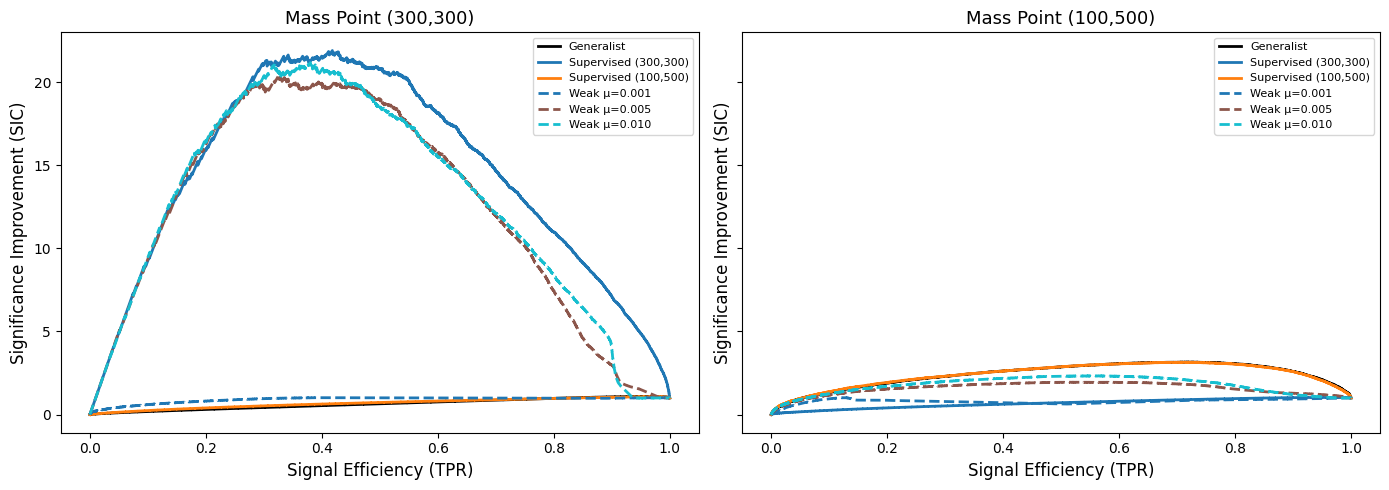

14057/14057 [==============================] - 29s 2ms/step


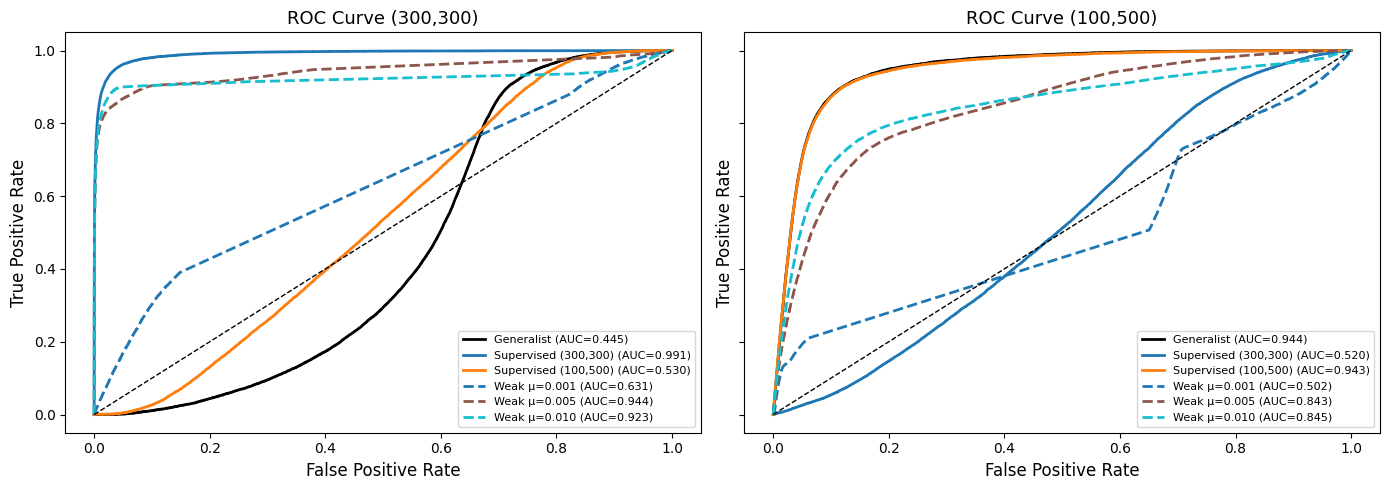

In [8]:
# ===== Imports =====
from matplotlib import colormaps
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ===== Configuration =====
injection_levels = [0.001, 0.005, 0.010]

# ===== Prepare injection colors =====
cmap = colormaps['tab10'].resampled(len(injection_levels))
injection_colors = {mu: cmap(i) for i, mu in enumerate(injection_levels)}

# ===== Plot helpers =====
def plot_sic_on_ax(ax, name, tpr, sic, color, linestyle):
    ax.plot(tpr, sic, label=name, color=color, linestyle=linestyle, linewidth=2)

def plot_roc_on_ax(ax, name, y_true, y_score, color, linestyle):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})",
            color=color, linestyle=linestyle, linewidth=2)

# ===== Main plotting =====
def main():
    models = train_models()
    mass_points = [(300, 300), (100, 500)]

    # -- SIC curves --
    fig_sic, axs_sic = plt.subplots(1, len(mass_points), figsize=(14, 5), sharey=True)
    for ax, (mx, my) in zip(axs_sic, mass_points):
        X_test, y_test = prepare_inputs(testsets[(mx, my)])
        # Generalist
        tpr, sic = compute_sic(y_test, models['gen'].predict(X_test).flatten())
        plot_sic_on_ax(ax, 'Generalist', tpr, sic, 'black', '-')
        # Specialists
        for spec_key, color in [('sup_300_300','tab:blue'),('sup_100_500','tab:orange')]:
            tpr_s, sic_s = compute_sic(y_test, models[spec_key].predict(X_test).flatten())
            mp_label = spec_key.split('_',1)[1].replace('_',',')
            plot_sic_on_ax(ax, f"Supervised ({mp_label})", tpr_s, sic_s, color, '-')
        # Weakly supervised
        for mu in injection_levels:
            key = f"weak_{mx}_{my}_{mu:.3f}"
            tpr_w, sic_w = compute_sic(y_test, models[key].predict(X_test).flatten())
            plot_sic_on_ax(ax, f"Weak μ={mu:.3f}", tpr_w, sic_w, injection_colors[mu], '--')
        ax.set_title(f"Mass Point ({mx},{my})", fontsize=13)
        ax.set_xlabel("Signal Efficiency (TPR)", fontsize=12)
        ax.set_ylabel("Significance Improvement (SIC)", fontsize=12)
        ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # -- ROC curves with AUC --
    fig_roc, axs_roc = plt.subplots(1, len(mass_points), figsize=(14, 5), sharey=True)
    for ax, (mx, my) in zip(axs_roc, mass_points):
        X_test, y_test = prepare_inputs(testsets[(mx, my)])
        # Generalist
        y_score = models['gen'].predict(X_test).flatten()
        plot_roc_on_ax(ax, 'Generalist', y_test, y_score, 'black', '-')
        # Specialists
        for spec_key, color in [('sup_300_300','tab:blue'),('sup_100_500','tab:orange')]:
            y_score_s = models[spec_key].predict(X_test).flatten()
            mp_label = spec_key.split('_',1)[1].replace('_',',')
            plot_roc_on_ax(ax, f"Supervised ({mp_label})", y_test, y_score_s, color, '-')
        # Weakly supervised
        for mu in injection_levels:
            key = f"weak_{mx}_{my}_{mu:.3f}"
            y_score_w = models[key].predict(X_test).flatten()
            plot_roc_on_ax(ax, f"Weak μ={mu:.3f}", y_test, y_score_w, injection_colors[mu], '--')
        # Diagonal
        ax.plot([0,1],[0,1], 'k--', linewidth=1)
        ax.set_title(f"ROC Curve ({mx},{my})", fontsize=13)
        ax.set_xlabel("False Positive Rate", fontsize=12)
        ax.set_ylabel("True Positive Rate", fontsize=12)
        ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

#if __name__ == '__main__':
   # main()


In [ ]:
#Train and save
from tensorflow.keras.models import save_model

def train_and_save_models(save_dir=None):
    """
    Train all models via train_models(), you can speficy the the directory of your choosing
    """
    save_dir = save_dir or os.getcwd()
    os.makedirs(save_dir, exist_ok=True)

    models = train_models()  

    for key, model in models.items():
        fname = f"{key}.h5"
        path = os.path.join(save_dir, fname)
        model.save(path)
        print(f"✔ Saved {key} → {fname}")

    return models

# Run this once to train & save
trained_models = train_and_save_models()


In [ ]:
# Load and plot
from tensorflow.keras.models import load_model
def load_models(save_dir=None):
    """
    Scan cwd (or save_dir) for *.h5 and load every model,
    using the filename (sans .h5) as the dict key.
    """
    save_dir = save_dir or os.getcwd()
    models = {}
    for path in glob.glob(os.path.join(save_dir, "*.h5")):
        key = os.path.splitext(os.path.basename(path))[0]
        models[key] = load_model(path)
    return models

def plot_all_sic(models):
    """
    For each mass point, gather (label, tpr, sic) from the right subset
    of models and call your plot_sic_curves().
    """
    for mx, my in mass_points:
        results = []
        X_test, y_test = prepare_inputs(testsets[(mx, my)])

        # generalist
        tpr, sic = compute_sic(y_test, models['gen'].predict(X_test).flatten())
        results.append(('gen', tpr, sic))

        # specialist
        sup_key = f"sup_{mx}_{my}"
        tpr, sic = compute_sic(y_test, models[sup_key].predict(X_test).flatten())
        results.append((sup_key, tpr, sic))

        # weakly supervised for spefic mass point
        for mu in injection_levels:
            wkey = f"weak_{mx}_{my}_{mu:.3f}"
            tpr, sic = compute_sic(y_test, models[wkey].predict(X_test).flatten())
            results.append((wkey, tpr, sic))

        plot_sic_curves(results, title=f"SIC Curves for ({mx},{my})")

# load & plot
models = load_models()
plot_all_sic(models)
